In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit atr, stop loss atr
# Variables :
# time - 15m, 1h
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# 1h three lines bullish, buy at 4h ema 38, out at bb_u, or (red vol > previous green, and red low < previous green open)
# additional, atr, buy 1 position only

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time
import os

In [4]:
from binance.client import Client
from dotenv import load_dotenv

# Get the path to the current directory
current_directory = os.getcwd()

# Specify the path to the .env file relative to the current directory
dotenv_path = os.path.join(current_directory, '.env')

# Load the environment variables from the .env file
load_dotenv(dotenv_path)

api_key = os.getenv('API_KEY')
api_secret = os.getenv('SECRET_KEY')

client = Client(api_key, api_secret, testnet = False)

In [5]:
timezone = 8
symbol = 'injusdt'
interval = '1h'


start_time = 1641028611000
end_time = round(time.time() * 1000)

def def_time():
    global start_time, end_time
    start_time = 1641028611000
    end_time = round(time.time() * 1000)
    # end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [6]:
dataframes = {}
# 先抓歷史資料好讓技術指標能成型
def create_raw(symbol, interval_arr, step):
    global start_time, end_time
    # Fetch the data using batch requests
    for interval in interval_arr:
        def_time()
        data = []    
        while start_time < end_time:
            
            limit = min(step, end_time - start_time + 1)  # Adjust the limit for the last batch
            response = client.get_klines(symbol=symbol.upper(), interval=interval, limit=limit, startTime=start_time)

            if len(response) == 0:
                break  # No more data available, exit the loop
            data.extend(response)
            start_time = response[-1][0] + 1

            # Convert the data to a DataFrame
        columns = [
            "Open_Time", "Open", "High", "Low", "Close", "Volume", "Close_Time",
            "Quote asset volume", "Number of trades", "Taker buy base asset volume",
            "Taker buy quote asset volume", "Ignore"
        ]
        raw_df = pd.DataFrame(data, columns=columns)   

        raw_df = raw_df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']]

        dataframes[f'df_{interval}'] = raw_df

In [7]:
interval_arr = ['1h', '4h']
start_time_arr = [1609492611000]
ema_arr = [8, 18, 38]

In [8]:
ep_per = 1.003
sl_per = 0.998
sl_atr = 2
tp_atr = 10
rsi_int = 14
kd_dir = 'Up'
rsi_high = 70

In [9]:
def get_klines(symbol, interval):
    global dataframes
    df = dataframes[f'df_{interval}']
    df = df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']].astype(float)
    df = df.set_index('Open_Time')

    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df = df[~df.index.duplicated(keep='first')]

    return df

In [10]:
loop_start_time = time.time()
raw_df = create_raw(symbol, interval_arr, step)
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")
print(raw_df)
print(dataframes)

Time taken to execute for loop: 2.4327967166900635 seconds
None
{'df_1h':            Open_Time        Open       Close        High         Low  \
0      1641031200000  8.44200000  8.35800000  8.44900000  8.34900000   
1      1641034800000  8.35300000  8.34500000  8.37900000  8.34500000   
2      1641038400000  8.34500000  8.37100000  8.37400000  8.32700000   
3      1641042000000  8.37000000  8.32500000  8.37800000  8.29700000   
4      1641045600000  8.32200000  8.32800000  8.33500000  8.29200000   
...              ...         ...         ...         ...         ...   
12515  1686088800000  7.32400000  7.39100000  7.40300000  7.29500000   
12516  1686092400000  7.39000000  7.37900000  7.49600000  7.37300000   
12517  1686096000000  7.38500000  7.33700000  7.38600000  7.31000000   
12518  1686099600000  7.34200000  7.24000000  7.35100000  7.23300000   
12519  1686103200000  7.24000000  7.24400000  7.28800000  7.22100000   

               Volume  
0       5473.40000000  
1       5417.

In [11]:
df = get_klines(symbol, interval_arr[0]).copy()
df = df.astype(float).round(4)

for interval in interval_arr:
    raw_df = get_klines(symbol, interval)
    # ema
    for ema in ema_arr:
        column_name = f'ema_{ema}_{interval}'
        df[column_name] = ta.trend.EMAIndicator(raw_df.Close, window=ema, fillna=True).ema_indicator()

    # rsi
#     rsi = ta.momentum.RSIIndicator(raw_df.Close, window = rsi_int)
#     df[f'rsi_{interval}'] = rsi.rsi()

    # atr
#         df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)


# reset index and set current index as a column
df = df.reset_index()

# set new index with integers
df = df.set_index(pd.RangeIndex(len(df)))

# time_format(timezone)
df['Open_Time'] = df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# fill up higher time frame empty values with equal interval between each value
df = df.replace('', np.nan)
df['ema_8_4h'] = df['ema_8_4h'].interpolate()
df['ema_18_4h'] = df['ema_18_4h'].interpolate()
df['ema_38_4h'] = df['ema_38_4h'].interpolate()
# df['rsi_4h'] = df['rsi_4h'].interpolate()

In [12]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
#     for i in (8, 18, 38):
#         df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()        
        
# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
#     rsi_int = 14
#     df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    df['slow_k']= ta.momentum.stoch(df['High'], df['Low'], df['Close'], 17, 5)
    df['slow_d'] = ta.momentum.stoch_signal(df['High'], df['Low'], df['Close'], 17, 5)
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [13]:
indicators(df, kd_dir)
print(df)

                 Open_Time   Open  Close   High    Low   Volume  ema_8_1h  \
0      2022-01-01 18:00:00  8.442  8.358  8.449  8.349   5473.4  8.358000   
1      2022-01-01 19:00:00  8.353  8.345  8.379  8.345   5417.6  8.355111   
2      2022-01-01 20:00:00  8.345  8.371  8.374  8.327   5071.3  8.358642   
3      2022-01-01 21:00:00  8.370  8.325  8.378  8.297   6377.9  8.351166   
4      2022-01-01 22:00:00  8.322  8.328  8.335  8.292   2851.8  8.346018   
...                    ...    ...    ...    ...    ...      ...       ...   
12515  2023-06-07 06:00:00  7.324  7.391  7.403  7.295  53667.8  7.337787   
12516  2023-06-07 07:00:00  7.390  7.379  7.496  7.373  90811.2  7.346945   
12517  2023-06-07 08:00:00  7.385  7.337  7.386  7.310  40665.8  7.344735   
12518  2023-06-07 09:00:00  7.342  7.240  7.351  7.233  62091.8  7.321461   
12519  2023-06-07 10:00:00  7.240  7.244  7.288  7.221  48648.5  7.304247   

       ema_18_1h  ema_38_1h  ema_8_4h  ema_18_4h  ema_38_4h      bb_u  \
0 

In [14]:
def conditions(df):

    df['c1'] = df['ema_8_1h'] >= df['ema_18_1h']
    df['c2'] = df['ema_18_1h'] >= df['ema_38_1h']
    df['c3'] = df['ema_8_4h'] >= df['ema_38_4h']
    # c5
#     df['c5'] = False
#     for i, row in df.iterrows():

#         if i >= 14:
#             if (df.loc[i-14:i-1, 'rsi_4h'] <= rsi_high).any():
#                 df.loc[i, 'c5'] = True

    # 條件達成
    df['signal'] = df.c1 & df.c2 & df.c3


    # 下一根進場
    df['open_entry'] = df['signal'] & (df['Low'] <= df['ema_18_4h'] * ep_per)
    
    return df

In [15]:
conditions(df)

,Open_Time,Open,Close,High,Low,Volume,ema_8_1h,ema_18_1h,ema_38_1h,ema_8_4h,...,bb_l,atr,slow_k,slow_d,kd_cross,c1,c2,c3,signal,open_entry
0,2022-01-01 18:00:00,8.442,8.358,8.449,8.349,5473.4,8.358000,8.358000,8.358000,NaN,...,NaN,0.000000,NaN,NaN,False,True,True,False,False,False
1,2022-01-01 19:00:00,8.353,8.345,8.379,8.345,5417.6,8.355111,8.356632,8.357333,NaN,...,NaN,0.000000,NaN,NaN,False,False,False,False,False,False
2,2022-01-01 20:00:00,8.345,8.371,8.374,8.327,5071.3,8.358642,8.358144,8.358034,8.354000,...,NaN,0.000000,NaN,NaN,False,True,True,True,True,True
3,2022-01-01 21:00:00,8.370,8.325,8.378,8.297,6377.9,8.351166,8.354655,8.356340,8.354889,...,NaN,0.000000,NaN,NaN,False,False,False,True,False,False
4,2022-01-01 22:00:00,8.322,8.328,8.335,8.292,2851.8,8.346018,8.351849,8.354887,8.355778,...,NaN,0.000000,NaN,NaN,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12515,2023-06-07 06:00:00,7.324,7.391,7.403,7.295,53667.8,7.337787,7.286391,7.317305,7.310254,...,6.928464,0.138522,82.189542,76.593445,True,True,False,False,False,False
12516,2023-06-07 07:00:00,7.390,7.379,7.496,7.373,90811.2,7.346945,7.296139,7.320469,7.306113,...,6.928094,0.137413,80.228758,77.450980,False,True,False,False,False,False
12517,2023-06-07 08:00:00,7.385,7.337,7.386,7.310,40665.8,7.344735,7.300440,7.321317,7.301972,...,6.932588,0.133027,73.366013,74.575163,False,True,False,False,False,False
12518,2023-06-07 09:00:00,7.342,7.240,7.351,7.233,62091.8,7.321461,7.294078,7.317147,7.301972,...,6.933745,0.131953,57.516340,72.908497,False,True,False,False,False,False


In [16]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
open_val = entry_df['Open']
low_val = entry_df['Low']
atr_val = entry_df['atr']
ema_18_val = entry_df['ema_18_4h']
vol_val = entry_df['Volume']

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = ema_18_val.at[index] * ep_per
        entry_df.at[index, 'stop_loss'] = low_val.at[index] * sl_per
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position and row['Close'] <= stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position and row['High'] >= row['bb_u']:
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
    elif in_position and (((vol_val.at[index] > vol_val.shift(1).at[index]) & # vol greater
                          (open_val.shift(1).at[index] < close_val.shift(1).at[index]) & # previous green candle
                          (open_val.at[index] > close_val.at[index]) & # current red candle
                          (low_val.at[index] < open_val.shift(1).at[index])) or # current low < previous green open
                          (low_val.at[index] <= stop_loss)): # current low > previous open
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan    
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry']) | (entry_df['position'] != '')]

print(entry_df)

                 Open_Time   Open  Close   High    Low   Volume  ema_8_1h  \
0      2022-01-01 18:00:00  8.442  8.358  8.449  8.349   5473.4  8.358000   
1      2022-01-01 19:00:00  8.353  8.345  8.379  8.345   5417.6  8.355111   
2      2022-01-01 20:00:00  8.345  8.371  8.374  8.327   5071.3  8.358642   
3      2022-01-01 21:00:00  8.370  8.325  8.378  8.297   6377.9  8.351166   
4      2022-01-01 22:00:00  8.322  8.328  8.335  8.292   2851.8  8.346018   
...                    ...    ...    ...    ...    ...      ...       ...   
12515  2023-06-07 06:00:00  7.324  7.391  7.403  7.295  53667.8  7.337787   
12516  2023-06-07 07:00:00  7.390  7.379  7.496  7.373  90811.2  7.346945   
12517  2023-06-07 08:00:00  7.385  7.337  7.386  7.310  40665.8  7.344735   
12518  2023-06-07 09:00:00  7.342  7.240  7.351  7.233  62091.8  7.321461   
12519  2023-06-07 10:00:00  7.240  7.244  7.288  7.221  48648.5  7.304247   

       ema_18_1h  ema_38_1h  ema_8_4h  ...  kd_cross     c1     c2     c3  

In [17]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位 usdt
pos_size = 200

col = ['Open_Time', 'Open', 'Close', 'High', 'Low', 'bb_u', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size / pos.at[index, 'entry_p']
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場

        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            
        # 停利：達成條件時收盤價
#         if (pos.at[index, 'position'] == 'Sell') & (pos.at[index, 'High'] >= pos.at[index, 'bb_u']) :
#             pos.at[index, 'exit_p'] = pos.at[index, 'bb_u']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
#                 break


        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


cumulative_values = []
cumulative_sum = 0

for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

max_drawdown = min(cumulative_values)
    
# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate],
          'Max_Drawdown': [round(max_drawdown,2)]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit    Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  913.92  56.49       162.7    -19.41          8        1600.0  571.20%   

  Win_Rate  Max_Drawdown  
0   66.41%        -12.17  

               Open_Time   Open  Close   High    Low      bb_u position  \
0    2022-01-01 20:00:00  8.345  8.371  8.374  8.327       NaN      Buy   
1    2022-01-01 21:00:00  8.370  8.325  8.378  8.297       NaN     Sell   
2    2022-01-02 03:00:00  8.368  8.370  8.379  8.354       NaN      Buy   
3    2022-01-02 04:00:00  8.379  8.499  8.499  8.360       NaN      Buy   
4    2022-01-02 12:00:00  8.446  8.386  8.464  8.360       NaN      Buy   
..                   ...    ...    ...    ...    ...       ...      ...   
403  2023-06-02 06:00:00  7.300  7.304  7.306  7.260  7.446694      Buy   
404  2023-06-02 07:00:00  7.302  7.278  7.309  7.245  7.448473      Buy   
405  2023-06-02 08:00:00  7.275  7.357  7.409  7.216  7.455214      Buy   
406  2023-06-02 09:00:00  7.360  7.524  7.

In [18]:
plt_df = pos[['Open_Time', 'position', 'amt']]

cumulative_sum = 0
agg_amts = []
stop_date = None

for index, row in plt_df.iterrows():
    if row['position'] == 'Buy':
        cumulative_sum += row['amt']
    elif row['position'] == 'Stop' or row['position'] == 'Sell':
        cumulative_sum += row['amt']
        stop_date = row['Open_Time']
        agg_amts.append((stop_date, cumulative_sum))
        cumulative_sum = 0

        
# Convert the list of tuples into a new dataframe
agg_df = pd.DataFrame(agg_amts, columns=['date', 'cumulative_sum'])
agg_df['cumulative_sum'] = agg_df['cumulative_sum'].apply(lambda x: -x)

print(agg_df['cumulative_sum'].sum())
print(agg_df)

970.4047999999999
                    date  cumulative_sum
0    2022-01-01 21:00:00         -1.2904
1    2022-01-02 15:00:00         -4.4295
2    2022-01-03 00:00:00         10.2320
3    2022-01-03 14:00:00         -1.6263
4    2022-01-04 00:00:00         -2.4669
..                   ...             ...
123  2023-04-06 09:00:00         -2.4035
124  2023-04-10 23:00:00         34.6848
125  2023-05-16 13:00:00          0.0562
126  2023-05-24 05:00:00         -8.4312
127  2023-06-02 10:00:00         44.0695

[128 rows x 2 columns]


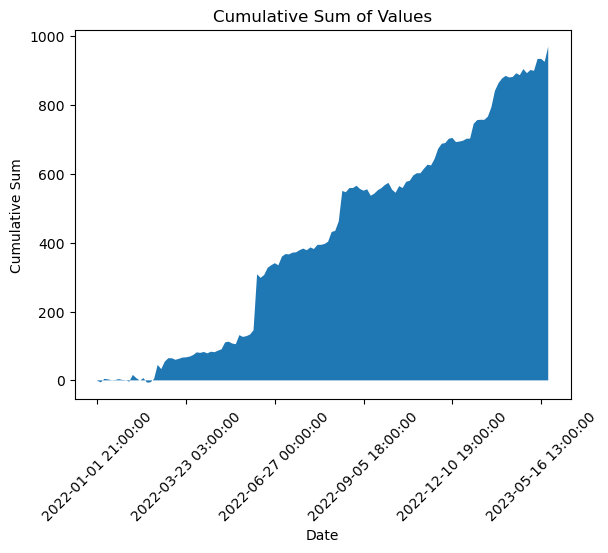

-12.166914900000194


In [19]:
cumulative_values = []
cumulative_sum = 0
for value in agg_df['cumulative_sum']:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

plt.fill_between(agg_df['date'], cumulative_values, 0)

plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')


n = 25  # Adjust the value of n as per your preference
plt.xticks(agg_df['date'][::n], rotation=45)
plt.show()

print(max_drawdown)
# print(cumulative_values)

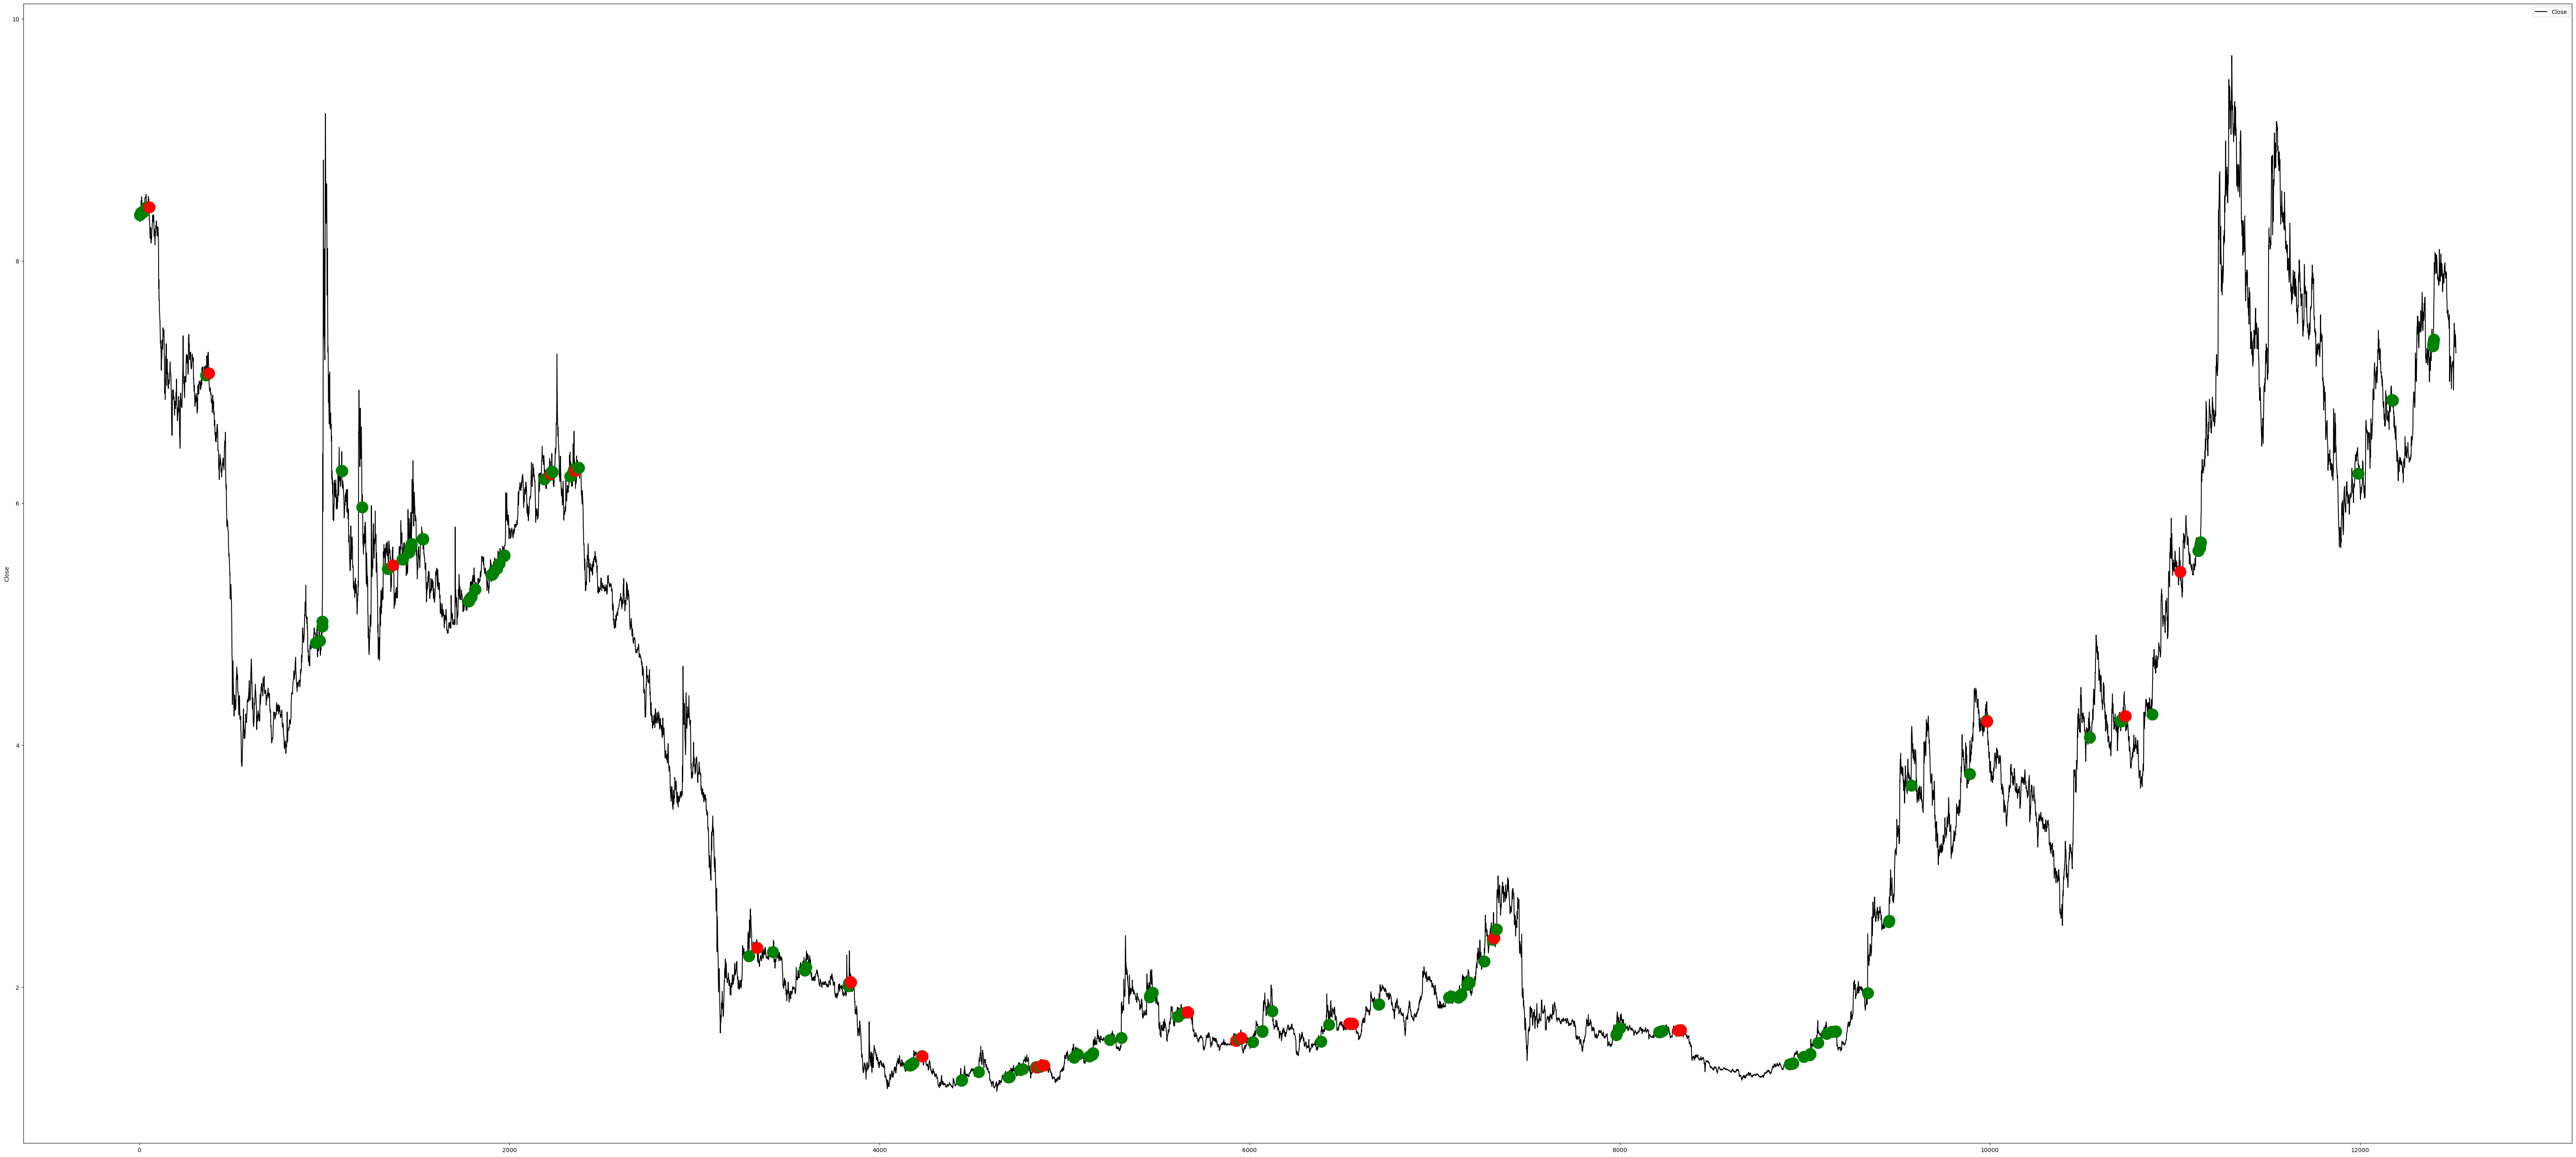

In [20]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位